In [1]:
import pandas as pd
import numpy as np
import uuid

from tqdm import tqdm_notebook
from tqdm import tqdm


from collections import OrderedDict


# Torch, Sklearn imports
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

## PyTorch Transformer
import transformers

## Roberta
from transformers import RobertaModel, RobertaTokenizer,  TFRobertaModel,RobertaForSequenceClassification, RobertaConfig
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from transformers import get_linear_schedule_with_warmup



In [2]:
df = pd.read_csv("fake reviews dataset.csv") 
df.head()   

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [3]:
label_to_id = {"CG" : 0, "OR" : 1}
df['label_id'] = df['label'].map(label_to_id)

In [4]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained("mytokenizer1h")

('mytokenizer1h\\tokenizer_config.json',
 'mytokenizer1h\\special_tokens_map.json',
 'mytokenizer1h\\vocab.json',
 'mytokenizer1h\\merges.txt',
 'mytokenizer1h\\added_tokens.json')

In [6]:
def prepare_features(texts, index, max_len, labels=None, tokenizer=None):
    text = str(texts[index])
    text = " ".join(text.split())  # تنظيف الفراغات

    enc = tokenizer.encode_plus( 
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt"
    )

    input_ids = enc['input_ids'].squeeze(0)        # Its shape is (max_len,)

    attention_mask = enc['attention_mask'].squeeze(0)

    result = {
        "ids": input_ids,
        "mask": attention_mask
    }

   # Add the label only if it's not None (skip during test mode)
    if labels is not None:
        label = torch.tensor(labels[index], dtype=torch.long)
        result["label"] = label

    return result


In PyTorch, a custom dataset should inherit from 
integration with 
torch.utils.data.Dataset . This allows easy
 DataLoader , which can then create mini-batches and shuffle data. By defining
 this class, we tell PyTorch how to get the number of examples (
 __len__ ) and how to get each
 example (
 __getitem__ ).

In [8]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, testing=False):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_len   = max_len
        self.testing   = testing

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        feats = prepare_features(
            texts     = self.texts,
            index     = index,
            max_len   = self.max_len,
            labels    = None if self.testing else self.labels,
            tokenizer = self.tokenizer  # Pass the correct tokenizer here
        )

        input_ids      = feats["ids"]
        attention_mask = feats["mask"]

        if self.testing:
            return input_ids, attention_mask  # Return tensors directly


        label = feats["label"]
        return input_ids, attention_mask, label



In [9]:
from sklearn.model_selection import train_test_split

train_df,  test_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=df['label_id'], random_state=42)

train_df = train_df.reset_index(drop=True)
test_df =  test_df.reset_index(drop=True)
print("TRAIN size:", len(train_df), "Test size:", len( test_df))

TRAIN size: 32345 Test size: 8087


In [10]:
from transformers import RobertaTokenizer
import pickle
# بعد train_test_split
with open("models/roBERTa_test_data1h.pkl", "wb") as f:
    pickle.dump((test_df["text_"].tolist(), test_df["label_id"].tolist()), f)


In [11]:
train_dataset = ReviewDataset(train_df['text_'].tolist(), train_df['label_id'].tolist(), tokenizer, max_len=256, testing=False)
test_dataset = ReviewDataset(test_df['text_'].tolist(), test_df['label_id'].tolist(), tokenizer, max_len=256, testing=False)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

In [12]:
x, m, y = train_dataset.__getitem__(760)
print(x)
print(m)
print(y)

tensor([    0,   100,   308,    80,     9,   209,     8,    33,    56,   117,
          743,     4,    38,    40,   489,   127,  1551,    11,   645,     7,
          458,   127,  3734,     4,    20, 15684,  2564, 41783,   352,     8,
            5,  2369,    16,   699,     4,    20,  5567, 12988,    32,   157,
        37342,     8,     5,  5567,  3745,    32,  3473,     4,    38,   101,
            5, 41783,  2564,     8,     5,  3149,   797,     4,    38,    33,
           67,  5324,    14,     5,  3149,    64,    28,  1224,    15,    73,
         1529,    25,   157,     4,    38,   109,    45,  5940,   209, 15684,
            7,  1268,    54,    16,  2811,  4906, 15684,    19,    10,  3149,
          797,     4,    20,  3149,   797,    16,   350,   650,    13,     5,
         3149,   797,     6,    53,    38,   524,    45,   686,    14,    38,
          524,    11,    10,   737,   147,    24,    40,    28,  7719,    13,
           14,  3508,     4,    38,    74,    45,  5940,   209, 

In [13]:
from transformers import RobertaModel
import torch.nn as nn

base_model = RobertaModel.from_pretrained(model_name)
class RobertaBinaryClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.roberta = base_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(base_model.config.hidden_size, 2)  # 2 classes

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        # outputs[0] is last hidden states of shape (batch_size, seq_len, hidden_size)
        s_hidden_state = outputs[0][:, 0, :]        # take <s> token's hidden state
        s_hidden_state = self.dropout(s_hidden_state)
        logits = self.classifier(s_hidden_state)
        return logits

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
base_model = RobertaModel.from_pretrained("roberta-base")
model = RobertaBinaryClassifier(base_model)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaBinaryClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [16]:
epochs = 3
train_steps_per_epoch = len(train_loader)
total_train_steps = train_steps_per_epoch * epochs
warmup_steps = int(0.1 * total_train_steps)  # 10% of steps for warmup

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_train_steps)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    #  Wrap train_loader with tqdm

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for input_ids, attention_mask, labels in loop:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)  
        loss   = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # accumulate metrics
        total_loss += loss.item()
        preds = logits.argmax(dim=1)  # predicted class index (0 or 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update the progress bar with some nice info
        loop.set_postfix({
            'loss': loss.item(),
            'accuracy': 100 * correct / total
        })

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

Epoch 1: Loss = 0.1580, Accuracy = 93.16%


Epoch 2: Loss = 0.0383, Accuracy = 98.61%


Epoch 3: Loss = 0.0124, Accuracy = 99.56%


In [19]:
torch.save(model.state_dict(), 'mymodel1h.pt')

In [20]:
model.load_state_dict(torch.load('mymodel1h.pt'))
model.eval()

C:\Users\moham\AppData\Local\Temp\ipykernel_15832\977122171.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mymodel1h.pt'))


RobertaBinaryClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [21]:

model.eval()

val_correct = 0
val_total = 0
val_loss = 0.0

all_preds = []
all_probs = []
all_labels = []

for input_ids, attention_mask, labels in test_loader:
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

    val_loss += loss.item()
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

    val_correct += (preds == labels).sum().item()
    val_total += labels.size(0)

    all_preds.extend(preds.cpu().numpy())
    all_probs.extend(probs[:, 1].cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

val_accuracy = 100 * val_correct / val_total
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f"Validation Loss: {val_loss / len(test_loader):.4f}")
print(f"Accuracy: {val_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Validation Loss: 0.1132
Accuracy: 96.92%
Precision: 0.9953
Recall: 0.9429
F1 Score: 0.9684
ROC AUC: 0.9987


In [46]:
print(f"Validation Loss: {val_loss / len(test_loader)}")
print(f"Accuracy: {val_accuracy/100}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Validation Loss: 0.11320180164979708
Accuracy: 0.9692098429578335
Precision: 0.9953002610966057
Recall: 0.9428642097452387
F1 Score: 0.9683729201066937
ROC AUC: 0.9986840891670722


In [22]:
print(val_correct)
print(val_total)

7838
8087


In [26]:
pd.set_option('display.max_colwidth', None)
test_df = test_df.reset_index(drop=True)

df_eval = pd.DataFrame({
    'TrueLabel': all_labels,
    'Predicted': all_preds
})

df_eval['text'] = test_df['text_']

false_positives_text = df_eval[(df_eval['TrueLabel'] == 0) & (df_eval['Predicted'] == 1)]
false_negatives_text = df_eval[(df_eval['TrueLabel'] == 1) & (df_eval['Predicted'] == 0)]

print("\n=== False Positives with Text ===")
print(false_positives_text[['text', 'TrueLabel', 'Predicted']].head())

print("\n=== False Negatives with Text ===")
print(false_negatives_text[['text', 'TrueLabel', 'Predicted']].head())




=== False Positives with Text ===
                                                                                                        text  \
33                                        Exactly as I wanted! Can't say enough good things about this tool.   
311   First time I bowled in a sporting event with my Dad I saw him wearing a dress and he was so impressed.   
1133                                                GREAT STORY,,,GOOD READING, COULDN'T PUT THE BOOK DOWN!!   
3274                     This bottle is amazing! It's a little large for my size 11 but fits my hand well!\n   
3357        Diferente por su argumento que esta su su reo de la historia de la personaje su esta su pregunta   

      TrueLabel  Predicted  
33            0          1  
311           0          1  
1133          0          1  
3274          0          1  
3357          0          1  

=== False Negatives with Text ===
                                                                                   

In [28]:
all_wrong_predictions = pd.concat([false_positives_text, false_negatives_text])

all_wrong_predictions = all_wrong_predictions.reset_index(drop=True)

all_wrong_predictions.to_csv("Wrong_Predictions.csv", index=False)

In [30]:
from IPython.display import display, HTML

pd.set_option('display.max_colwidth', None) 
display(HTML(all_wrong_predictions.to_html(index=False)))

TrueLabel,Predicted,text
0,1,Exactly as I wanted! Can't say enough good things about this tool.
0,1,First time I bowled in a sporting event with my Dad I saw him wearing a dress and he was so impressed.
0,1,"GREAT STORY,,,GOOD READING, COULDN'T PUT THE BOOK DOWN!!"
0,1,This bottle is amazing! It's a little large for my size 11 but fits my hand well!\n
0,1,Diferente por su argumento que esta su su reo de la historia de la personaje su esta su pregunta
0,1,Appears well made (in comm't that it's an inch longer than a standard toilet seat)
0,1,Beautiful rug. Ive had it for 3 years and love it.
0,1,Love it. Can easily be worn as a nightgown.
0,1,My fish really enjoy this food. It's a good price and my fish seem to like it.
0,1,Works as intended. Gives me a more professional feel and comfortable fit. Would not purchase again. Great product.


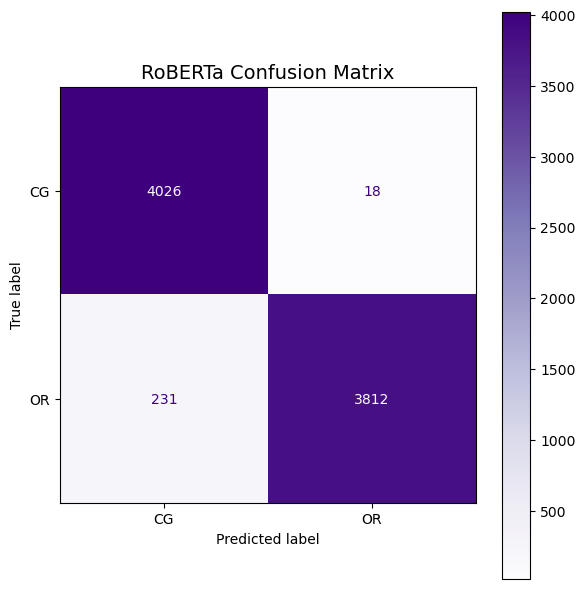

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt  

cm = confusion_matrix(all_labels, all_preds)
labels = ['CG', 'OR']  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Purples', ax=ax, values_format='d')

plt.title("RoBERTa Confusion Matrix", fontsize=14)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()



In [38]:
with open("models/roBERTa_test_data1h.pkl", "rb") as f:
    test_texts, test_labels = pickle.load(f)

test_df_export = pd.DataFrame({
    "text": test_texts,
    "label": test_labels
})

test_df_export.to_csv("TestSet_Exported.csv", index=False)